# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: ML Modell erstellen

Hier in diesem Notebook erstellen wir unsere Machine Learning Modelle.

---

# Libraries Importieren

In [1]:
# CODE

# Data Science Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn Libraries

## import logistic regression
from sklearn.linear_model import LogisticRegression

## Train Validation Split
from sklearn.model_selection import train_test_split

## import metrics 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Decision Tree

## Random Forest



# Daten einlesen

In [2]:
# CODE

# File: Alle_Messungen.csv (Raw Data) einlesen
raw_unprocessed_data = pd.read_csv("..\Sensor_Data-Wrangling-und-EDA\Alle_Messungen.csv", index_col=0)

# get information about raw_unprocessed_data
raw_unprocessed_data.info()

# display head 
raw_unprocessed_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2134005 entries, 0 to 2134004
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   time             object 
 1   Accelerometer_x  float64
 2   Accelerometer_y  float64
 3   Accelerometer_z  float64
 4   Gyroscope_x      float64
 5   Gyroscope_y      float64
 6   Gyroscope_z      float64
 7   Magnetometer_x   float64
 8   Magnetometer_y   float64
 9   Magnetometer_z   float64
 10  Orientation_qx   float64
 11  Orientation_qy   float64
 12  Orientation_qz   float64
 13  id               object 
 14  user             object 
 15  class            object 
 16  id_combined      object 
dtypes: float64(12), object(5)
memory usage: 293.1+ MB


,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,2023-02-27 15:02:04.548,0.000,-3.552,-9.140,NaN,NaN,NaN,NaN,NaN,NaN,0.161765,-0.088290,-0.470671,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
1,2023-02-27 15:02:17.156,0.000,9.722,1.278,NaN,NaN,NaN,NaN,NaN,NaN,-0.217750,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,2023-02-27 15:02:31.574,-0.728,9.779,0.000,NaN,NaN,NaN,NaN,NaN,NaN,-0.420650,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,2023-02-27 15:02:16.685,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,43.5,-13.143750,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,2023-02-27 15:02:32.295,NaN,NaN,NaN,NaN,NaN,NaN,-13.012501,0.0,20.587502,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


# Baseline Modell 

Im Baseline Modell verwenden wir die unprozessierten Daten.  
Dabei werden die NaN Zeilen entfernt und anschliessend im Verhältnis 80:20 in Trainings- und Validierungsdaten aufgeteilt. 

Anschliessend wird ein Decision Tree Classifier Modell erstellt, trainiert und anschliessend mittels validierungs Daten die Accuracy Metrik berechnet und die Klassifizierungen mittels einer Confusion Matrix dargestellt. 

Bemerkung: 
Die Gewichtung der Klassen werden im Baseline Modell nicht mit berücksichtigt.


In [3]:
# remove na rows from raw_unprocessed_data
raw_unprocessed_data = raw_unprocessed_data.dropna(axis = 0)

# drop uneccessary columns for the baseline modell
baseline_data = raw_unprocessed_data.drop(['time', 'id', 'user', 'id_combined'], axis = 1)

# standarize data column wise
#baseline_data = (baseline_data - baseline_data.mean()) / baseline_data.std()

# split data into train and validation set
baseline_data_train, baseline_data_val = train_test_split(baseline_data, test_size=0.2, random_state=42)

# split into X input data and y target data
baseline_data_y, baseline_data_val_y = baseline_data_train['class'], baseline_data_val['class']
baseline_data_X, baseline_data_val = baseline_data_train.drop('class', axis = 1), baseline_data_val.drop('class', axis = 1)

# display train X, y, and val X, y
display('baseline trainingsdata X', baseline_data_X)
display('baseline trainingsdata y', baseline_data_y)

display('baseline validierungsdata X', baseline_data_val)
display('baseline validierungsdata y', baseline_data_val_y)


'baseline trainingsdata X'

,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz
570186,-0.754055,-0.073621,-0.954518,0.037839,0.385856,-0.120787,-19.358063,49.138557,-5.912521,-0.236063,-0.679551,0.635552
2108380,3.147991,-2.094826,-1.178710,0.866288,-0.299288,-0.045886,-37.862854,14.415512,27.774509,-0.774353,0.010853,-0.606766
1751489,4.596284,-5.328203,-1.946796,0.664318,0.323629,0.485467,2.592285,38.175156,29.571617,0.787272,-0.278224,0.324164
1044852,-0.136547,0.214293,-0.349933,-0.006015,0.035248,-0.004528,-37.439968,25.643082,-9.307327,0.532174,0.691840,-0.093813
1123083,0.031689,-0.017323,0.043801,0.005479,-0.011004,0.002985,-5.999847,46.011879,12.290688,-0.585319,0.274651,-0.526525
...,...,...,...,...,...,...,...,...,...,...,...,...
259850,-8.532163,1.904685,3.702847,-1.855832,0.209795,0.095900,-39.474915,-10.240921,4.444977,0.337204,-0.695986,0.226658
1451833,-0.010199,0.025701,0.023768,-0.003448,0.013380,-0.003944,-6.430534,-32.635460,-42.921181,0.663661,-0.057279,0.021828
132510,-4.449868,7.409571,-1.569236,-2.476552,-2.287566,-1.543015,-34.521317,23.810349,25.299042,0.614369,-0.355832,0.689280
672512,1.609312,15.361463,6.629589,3.675445,-4.455920,-2.186309,-21.886078,42.471172,19.699253,-0.275967,0.648794,-0.663277


'baseline trainingsdata y'

570186            Laufen
2108380       Velofahren
1751489    Weiping_Zhang
1044852           Sitzen
1123083           Stehen
               ...      
259850            Laufen
1451833    Treppenlaufen
132510            Laufen
672512            Rennen
122536            Laufen
Name: class, Length: 1676212, dtype: object

'baseline validierungsdata X'

,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz
18513,3.524300,-0.803657,4.009709,0.443403,1.233825,-0.351676,52.355701,-156.236633,81.223351,-0.836092,0.102904,0.041339
187617,3.335409,2.918419,-4.775851,0.184391,-0.118526,-0.250554,-21.236603,30.529831,30.258881,0.767104,-0.085449,0.553225
973071,0.012641,0.042540,-0.017945,-0.004230,-0.002306,0.001676,-40.620762,25.661835,-8.823334,0.300391,0.820962,-0.195038
2013826,-1.213435,1.211787,-1.907808,0.223646,0.566779,0.422592,-18.900055,-13.535538,35.605244,0.676141,-0.684101,0.253244
1207851,-0.040867,-0.032242,-0.012143,0.001927,0.000194,-0.002402,17.811207,48.874023,-5.375923,0.719080,0.172296,-0.047323
...,...,...,...,...,...,...,...,...,...,...,...,...
2011515,-2.252075,0.536133,1.219425,1.168803,0.665887,1.173813,-33.346603,-10.633240,26.203655,0.497998,-0.740622,0.369200
655949,0.785279,2.217055,9.141278,-2.788602,1.101882,-1.261383,-14.655083,-30.500893,-29.492569,-0.265602,0.517760,0.767709
1352944,-0.026796,-0.012234,-0.034018,-0.001410,-0.005432,0.004662,-39.684769,14.161896,-13.736031,-0.009326,0.712058,-0.431250
1700145,2.530267,-0.393810,-1.040597,-1.522598,-1.322607,-1.392914,-36.981232,22.126503,-2.518234,-0.150968,-0.827668,0.295789


'baseline validierungsdata y'

18513             Laufen
187617            Laufen
973071            Sitzen
2013826       Velofahren
1207851           Stehen
               ...      
2011515       Velofahren
655949            Rennen
1352944           Stehen
1700145    Weiping_Zhang
754817            Rennen
Name: class, Length: 419053, dtype: object

In [13]:
# create a model
baseline_model = LogisticRegression()

# fit the model
baseline_model.fit(baseline_data_X, baseline_data_y)

# predict the model
baseline_model_pred = baseline_model.predict(baseline_data_val)

# get all unique values from baseline_model_pred
baseline_model_pred_unique = pd.Series(baseline_model_pred).unique()

# calculate accuracy score
baseline_model_accuracy = accuracy_score(baseline_data_val_y, baseline_model_pred)

print('baseline model accuracy: ', baseline_model_accuracy)

# plot confusion matrix for baseline model with seaborn
# create confusion matrix
baseline_model_confusion_matrix = confusion_matrix(baseline_data_val_y, baseline_model_pred)

# plot confusion matrix
# plot with sklearn display confusion matrix
ConfusionMatrixDisplay(baseline_model_confusion_matrix, display_labels=baseline_model.classes_)


c:\Users\Si Ben Tran\venv\cdl1\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


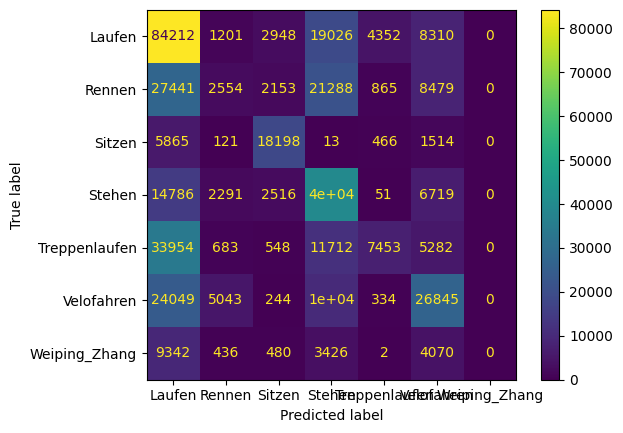

In [17]:
# display with sklearn confusionmatrixdispla with labels and plot
ConfusionMatrixDisplay(baseline_model_confusion_matrix, display_labels=baseline_model.classes_, ).plot()


---
# Modell-01 - Decision Tree

In [ ]:
# CODE

# Modell erstellen

# Modell trainieren

# Modell Accuracy mittels Validierungsdatensatz

# Confusion Matrix erstellen

## Fazit zu Modell-01 - Decision Tree

blabla

---

# Modell-02 - Random Forest

In [ ]:
# CODE

# Modell erstellen

# Modell trainieren

# Modell Accuracy mittels Validierungsdatensatz

# Confusion Matrix erstellen

## Fazit zu Modell-02 - Random Forest

blabla

---

# Modelle vergleichen


In [ ]:
# CODE

# Barplot erstellen x-Achse = Modelle, y-Achse = Accuracy Score



## Fazit zu ML Modelle 

blabla

---